In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as tfs
import torch.utils.data as data
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import kagglehub

import os
import warnings

warnings.filterwarnings('ignore')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# constants
NUM_CLASSES = 2

NUM_EPOCH = 5

BATCH_SIZE = 128

## Binary classifier

We're gonna do some easy image binary classifier. Of course we'll classify cats and dogs, because <s>I don't have any creativity</s> it's quite easy for CV practice (and everyone loves cats, or dogs, or whatever you like...)

### Collect and load data

So, first of all we need some data. I'll use [this dataset](https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset/data) from Kaggle.

In [4]:
path = kagglehub.dataset_download('shaunthesheep/microsoft-catsvsdogs-dataset')

100%|██████████| 788M/788M [01:15<00:00, 11.0MB/s] 

Extracting files...


I wanna pay attention on the images. If you just use the dataset as usual, you'll have errors of not matching size or Python won't even read an image in training. The reason for this - some images are corrupted or in grayscale. To help whoever reads this and wants to try the same thing, I left *process_dataset.py* for you. It's a simple script, that will remove these bad images. Just put the path to dataset on your computer to this file and run it. It's not a miner, I swear :)

In [39]:
class CatsAndDogsDataset(data.Dataset):
    def __init__(self, dir_path, transform=None):
        super().__init__()

        self.path = dir_path
        self.transform = transform

        self.length = 0
        self.files = []

        self.format = {'Cat': 0, 'Dog': 1}
        for dir, target in self.format.items():
            images_path = os.path.join(self.path, dir)
            images = os.listdir(images_path)
            self.length += len(images)
            self.files.extend(map(lambda x: (os.path.join(images_path, x), target), images))

    def __getitem__(self, index):
        image_path, target = self.files[index]
        img = Image.open(image_path)

        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return self.length


In [ ]:
transforms = tfs.Compose([
    tfs.Resize((128, 128)),         # resize images of different size (if you are not as lazy as me, you can you fully convolution layers)
    tfs.ToTensor(),                 # PyTorch only deal with tensor, not images
    tfs.ToDtype(torch.float32),     # cast integers to float for later normalizing
    tfs.Normalize((0.5,), (0.5,))   # normalize images (each pixel from 0 to 1)
])

In [41]:
cats_and_dogs = CatsAndDogsDataset(path, transform=transforms)
print(f'Total number of images in dataset: {len(cats_and_dogs)}')

Total number of images in dataset: 24931


Eventually, we have 24931 images. Originally there are 25002 images, which means that 71 of them was either corrupted or not in RGB.

### Train-test split

Nothing special here, just spliting dataset on train and test.

In [42]:
train_size = int(0.8 * len(cats_and_dogs))
test_size = len(cats_and_dogs) - train_size

train_ds, test_ds  = data.random_split(cats_and_dogs, [train_size, test_size])

### Model

Now we finally gonna do interesting (not really) stuff - designing our model. Since it's just a simple educational project, we'll use CNN architecture. That's should be enough for our purposes.

In [50]:
class BinaryImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 256)

        self.fc3 = nn.Linear(256, 2)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool(x)

        x = self.relu(self.conv2(x))
        x = self.max_pool(x)

        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.max_pool(x)
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        x = self.fc3(x)
        return x


I just don't know how to comment this, like we use a bunch of convolution layers and ReLU as activation and etc... As I mentioned before, there could be used fully convolution layers instead of *nn.Linear* to avoid problem of images of different sizes. Let's say it's your homework :]

In [51]:
model = BinaryImageClassifier()
model.to(device)
summary(model)

Layer (type:depth-idx)                   Param #
BinaryImageClassifier                    --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            295,168
├─Flatten: 1-6                           --
├─Linear: 1-7                            67,109,888
├─Linear: 1-8                            262,400
├─Linear: 1-9                            514
├─ReLU: 1-10                             --
Total params: 67,761,218
Trainable params: 67,761,218
Non-trainable params: 0

Now we gonna train the model, nothing special here (yeah, I have no clue how explain things)

In [54]:
train_data = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_data = data.DataLoader(test_ds, batch_size=BATCH_SIZE, drop_last=True)

In [55]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

for _e in range(NUM_EPOCH):
    # training
    model.train()
    for x_train, y_train in tqdm(train_data, desc=f'Epoch {_e + 1}/{NUM_EPOCH}'):
        x_train, y_train = x_train.to(device), y_train.to(device)

        predicted = model(x_train)
        loss = loss_func(predicted.reshape(BATCH_SIZE, -1), y_train)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    # test loss
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_test, y_test in test_data:
            x_test, y_test = x_test.to(device), y_test.to(device)
            predicted = model(x_test)
            _, labels = torch.max(predicted, dim=1)  # function returns (max, max_indices)
            correct += (labels == y_test).sum().item()
            total += len(y_test)

    accuracy = correct / total
    print(f'Test accuracy after on {_e + 1} epoch: {accuracy:.2f}')

Epoch 1/5: 100%|██████████| 155/155 [05:40<00:00,  2.20s/it]


Test accuracy after on 1 epoch: 0.69


Epoch 2/5: 100%|██████████| 155/155 [05:43<00:00,  2.22s/it]


Test accuracy after on 2 epoch: 0.76


Epoch 3/5: 100%|██████████| 155/155 [05:47<00:00,  2.24s/it]


Test accuracy after on 3 epoch: 0.79


Epoch 4/5: 100%|██████████| 155/155 [05:48<00:00,  2.25s/it]


Test accuracy after on 4 epoch: 0.81


Epoch 5/5: 100%|██████████| 155/155 [05:47<00:00,  2.24s/it]


Test accuracy after on 5 epoch: 0.82


So, as we can see, we have something around 80% of accuracy after only 5 epochs (yeah, that was on CPU, I don't have Nvidia GPU, yes, I'm poor, you can laugh here). That's already good enough, but it could be better with more epochs (also try expirimenting with learning rate). I'm doing it only for practice (and some pet project in my portfolio), so I won't go deeper with this model.

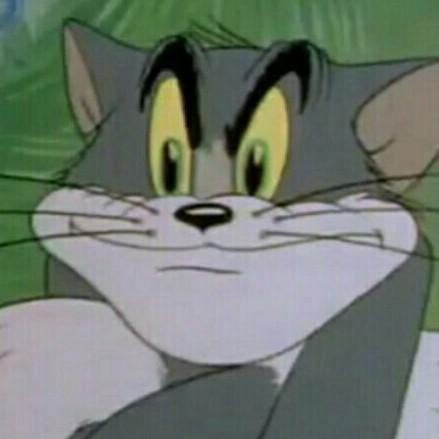

In [58]:
cat_img = Image.open('tom.jpg')
cat_img

In [68]:
model.eval()
prediction = model(transforms(cat_img).reshape(1, 3, 128, 128))
_, label = torch.max(prediction, 1)
print('Cat' if label == 0 else 'Dog')

Cat


In [70]:
torch.save(model.state_dict(), 'weights/cnn_model.tar')